In [1]:
import keras
import numpy as np
import pandas as pd
import os
from PIL import Image


Using TensorFlow backend.


In [2]:
imgs = list(os.listdir(os.path.join('',"DATA_IMAGES")))
boxes = list(os.listdir(os.path.join('',"DATA_BOXES")))

In [3]:
def txtToArray(path):
    f = open(path)
    tokens=f.read().split()
    for i in range(0,len(tokens)): tokens[i]=tokens[i].split(',')
    A=np.array(tokens, dtype=np.int)
    return(A)

In [81]:
def __getitem__(idx):
    i = 1+int(idx/100)
    j = 1+(idx%100)
    imgStr = "Image"+str(i)+"_"+str(j)+".jpg"
    boxStr = "Box"+str(i)+"_"+str(j)+".txt"
    img_path = os.path.join('', "DATA_IMAGES",imgStr)
    box_path = os.path.join('',"DATA_BOXES",boxStr)
    box_array = txtToArray(box_path)
    im = Image.open(img_path).convert("RGB")
    boxes = []
    for k in range(len(box_array)):  #get the bounding boxes for all hands in image with xmin,ymin,xmax,ymax coords
        if box_array[k,2] != 0:
            xmin = box_array[k,0]
            ymin = box_array[k,1]
            xmax = xmin+box_array[k,2]
            ymax = ymin + box_array[k,3]
            boxes.append([xmin,ymin,xmax,ymax])
    if len(boxes)==0:
        idx = (idx+1)%4800
        return __getitem__(idx)
    big_box = [1199,1199,0,0]         #big box is the Region of Interest, essentially a cropping of the image
    for k in range(len(boxes)):
        if boxes[k][0] < big_box[0]:
            big_box[0] = boxes[k][0]
        if boxes[k][1] < big_box[1]:
            big_box[1] = boxes[k][1]
        if boxes[k][2] > big_box[2]:
            big_box[2] = boxes[k][2]
        if boxes[k][3] > big_box[3]:
            big_box[3] = boxes[k][3]
    im_array = np.asarray(im)
    ROI = im_array[big_box[1]:big_box[3],big_box[0]:big_box[2],:]          #a crop of the image
    ROI_Image = Image.fromarray(ROI, 'RGB')
    ROI_Resize = ROI_Image.resize((32,32))
    ROI_npArr = np.asarray(ROI_Resize)
    #Image_Resize = np.asarray(im.resize((64,64)))
    label = 0
    if i>0 and i<13:
        label = 0    #cards
    if i>12 and i<25:
        label = 1    #chess
    if i>24 and i<37:
        label = 2    #jenga
    if i>36 and i<49:
        label = 3   #puzzle
    return ROI_npArr, label

In [82]:
X_train = []
Y_train = []
X_test = []
Y_test = []
for idx in range(4800):
    i = 1+int(idx/100)  #video 
    j = 1+(idx%100)
    ROI, activity = __getitem__(idx)
    #lets take first 11 videos as training for each activity
    toTrain = (i-1)%12
    if (toTrain >= 0) and (toTrain <= 10):
        X_train.append(ROI)
        Y_train.append(activity)
    else:
        X_test.append(ROI)
        Y_test.append(activity)

In [83]:
X_tr = np.array(X_train)
Y_tr = np.array(Y_train)
X_te = np.array(X_test)
Y_te = np.array(Y_test)

In [84]:
from keras.utils import to_categorical
Y_tr = to_categorical(Y_tr)
Y_te = to_categorical(Y_te)

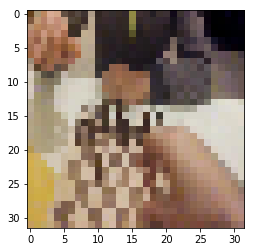

In [85]:
import matplotlib.pyplot as plt
plt.imshow(X_tr[1501])
plt.show()

In [86]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,Dropout,Activation
model = Sequential()

In [87]:
model.add(Conv2D(128,kernel_size=3,activation='relu',input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(32,activation='relu'))
model.add(Dense(4 ,activation='softmax'))



In [88]:
sgd = optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics = ['accuracy'])


In [93]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 13, 64)        73792     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                73760     
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 132       
Total para

In [90]:
model.fit(X_tr,Y_tr,validation_data=(X_te,Y_te),epochs=10,shuffle=True)

Train on 4400 samples, validate on 400 samples
Epoch 1/10
4400/4400 [==============================] - 7s 2ms/step - loss: 6.2763 - acc: 0.4186 - val_loss: 4.6289 - val_acc: 0.6000

In [91]:
preds = model.predict(X_te)
counter = 0
for i in range(len(preds)):
    preds[i] = np.round(preds[i],0)
    if np.array_equal(Y_te[i],preds[i]):
        counter = counter +1

In [95]:
video_scores = [0,0,0,0]
for i in range(len(preds)):
    video = int(i/100)
    if np.array_equal(Y_te[i],preds[i]):
        video_scores[video] = video_scores[video]+1
print(video_scores)    #this gives amount of frames correctly classified in each of the 4 videos (cards,chess,jenga,puzzle)

[89, 88, 76, 47]
